# TIME SERIES

In [46]:
## import the necessary libraries for time series modelling
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import warnings
warnings.filterwarnings('ignore')

### Data Exploration

In [2]:
## read in train and test dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Data Preprocessing

In [3]:
## setting the index as Date (train_df)

train_df.index = pd.to_datetime(train_df.Date , format = '%d/%m/%Y')
train_df.drop('Date',axis = 1, inplace = True)
train_df.head()

,T,RH,Gas,Value
Date,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000
2016-03-16,9.833333,64.069791,CO,995.250000
2016-03-17,11.292708,51.107292,CO,1025.250000
2016-03-18,12.866319,51.530903,CO,1064.444444
2016-03-19,16.016667,48.843750,CO,1088.741667


In [4]:
## setting the index as Date (test_df)
test_df.index = pd.to_datetime(test_df.Date , format = '%d/%m/%Y')
test_df.drop(['Date','id'],axis = 1, inplace = True)
test_df.head()

,T,RH,Gas
Date,,,
2017-02-06,6.616667,51.734375,CO
2017-02-07,7.613194,43.930903,CO
2017-02-08,7.252083,50.966667,CO
2017-02-09,7.473611,50.166319,CO
2017-02-10,5.571875,46.604167,CO


## CO GAS

In [5]:
## extract CO gas only
CO = train_df.loc[train_df['Gas'] == "CO"]
CO = CO.drop(columns=['Gas'])
CO.head()

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,1053.200000
2016-03-16,9.833333,64.069791,995.250000
2016-03-17,11.292708,51.107292,1025.250000
2016-03-18,12.866319,51.530903,1064.444444
2016-03-19,16.016667,48.843750,1088.741667


### ACF and PACF Plots to obtain p,d,q values

From the PACF plot, p=1
From the ACF plot, q=1
Since time series is stationary, d=0

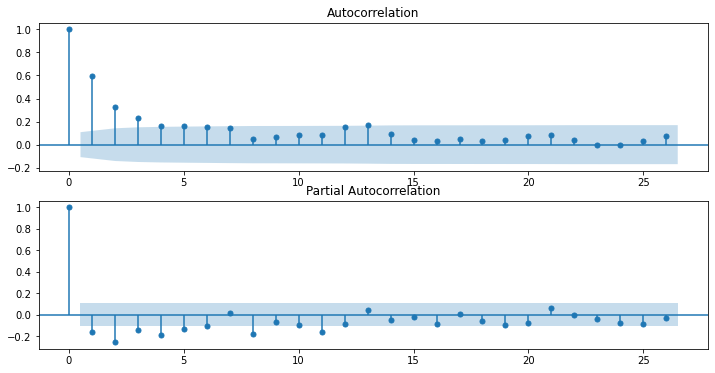

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(CO['Value'], ax=ax[0])
plot_pacf(CO['Value'].diff()[1:], ax=ax[1])
plt.show()

### ARIMA GridSearch

In [42]:
## split into train and test data
train_data = CO[CO.index<='2016-08-20']
test_data = CO[CO.index>'2016-08-20']

In [55]:
exogCO = CO[['T','RH']]

arima_model = ARIMA(CO['Value'], order=(1,0,1), exog=exogCO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Value   No. Observations:                  328
Model:                     ARMA(1, 1)   Log Likelihood               -1871.861
Method:                       css-mle   S.D. of innovations             72.746
Date:                Wed, 27 Jul 2022   AIC                           3755.723
Time:                        23:32:11   BIC                           3778.481
Sample:                    03-15-2016   HQIC                          3764.803
                         - 02-05-2017                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         690.8546     15.173     45.532      0.000     661.116     720.593
T               0.6649      0.459      1.449      0.147      -0.234       1.564
RH              3.5895      0.402      8.938      0.000       2.802       4.377
ar.L1.Value     0.5101      0.068      7.449      0.000       0.376       0.644
ma.L1.Value     0.2790      0.076      3.669      0.000       0.130       0.428
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9604           +0.0000j            1.9604            0.0000
MA.1           -3.5838           +0.0000j            3.5838            0.5000
-----------------------------------------------------------------------------
"""

In [66]:
## define CO test set
CO_test = test_df.loc[test_df['Gas'] == "CO"]
CO_test = CO_test.drop(columns=['Gas'])

forecast = arima_model.forecast(steps=63, exog=CO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF = forecastDF.drop(forecastDF.index[1:3])
forecastDF = forecastDF.T
forecastDF
forecastDF.to_csv('CO Forecast.csv', index=False)

In [10]:
orders = [(1,0,1),(1,0,2),
          (1,1,1),(1,1,2),
          (2,0,1),(2,0,2),
          (2,1,1),(2,1,2),
          (3,0,1),(3,0,2),
          (3,1,1),(3,1,2)]

metrics_df = pd.DataFrame(columns=['model', 'AIC', 'BIC'])

for order in orders:
    print("trying "+ str(order))
    try:
        arima_model = ARIMA(CO['Value'], order=order, exog=exogCO).fit()
        metrics_df = metrics_df.append({'model':order, 'AIC':arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
    except:
        print('failed')

trying (1, 0, 1)
trying (1, 0, 2)
trying (1, 1, 1)
trying (1, 1, 2)
trying (2, 0, 1)
trying (2, 0, 2)
trying (2, 1, 1)
trying (2, 1, 2)
trying (3, 0, 1)
trying (3, 0, 2)
failed
trying (3, 1, 1)
trying (3, 1, 2)


In [11]:
metrics_df = metrics_df.sort_values('AIC')
metrics_df

,model,AIC,BIC
0,"(1, 0, 1)",3755.722885,3778.480966
1,"(1, 0, 2)",3757.718608,3784.269703
4,"(2, 0, 1)",3757.719816,3784.270911
5,"(2, 0, 2)",3759.575774,3789.919883
8,"(3, 0, 1)",3760.712784,3791.056893
3,"(1, 1, 2)",4281.182675,4307.712397
6,"(2, 1, 1)",4282.240360,4308.770081
9,"(3, 1, 1)",4282.397890,4312.717572
7,"(2, 1, 2)",4282.757958,4313.077640
10,"(3, 1, 2)",4284.703487,4318.813129


### SARIMAX 

Since this data has seasonality, we will use SARIMAX instead of ARIMA

In [83]:
exogCO = CO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(CO['Value'], order=(2,1,2),
                      seasonal_order=(1, 1, 1, 7), trend='n',exog=exogCO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -1815.967
Date:                             Thu, 28 Jul 2022   AIC                           3649.933
Time:                                     00:21:28   BIC                           3683.848
Sample:                                 03-15-2016   HQIC                          3663.476
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.3347      0.472      0.709      0.479      -0.591       1.260
RH             3.8765      0.404      9.588      0.000       3.084       4.669
ar.L1         -0.3008      0.079     -3.806      0.000      -0.456      -0.146
ar.L2          0.6845      0.066     10.415      0.000       0.556       0.813
ma.L1         -0.0020      0.130     -0.015      0.988      -0.257       0.253
ma.L2         -0.9980      0.104     -9.610      0.000      -1.202      -0.794
ar.S.L7       -0.0880      0.061     -1.432      0.152      -0.209       0.032
ma.S.L7       -0.9244      0.033    -27.747      0.000      -0.990      -0.859
sigma2      4625.3242   3.46e-05   1.34e+08      0.000    4625.324    4625.324
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):                 4.05
Prob(Q):                              0.17   Prob(JB):                         0.13
Heteroskedasticity (H):               1.67   Skew:                            -0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+24. Standard errors may be unstable.
"""

In [84]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=CO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('CO AA Forecast.csv', index=False)

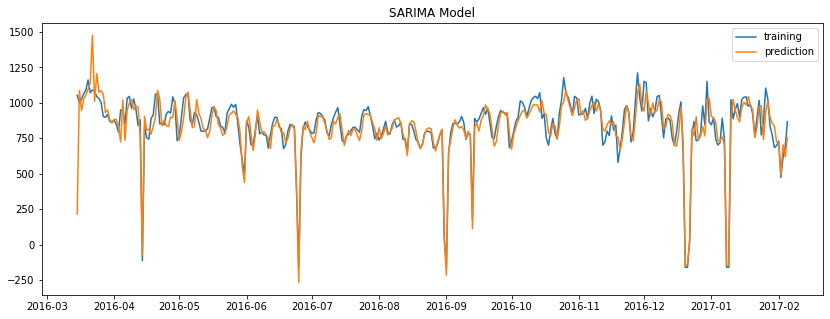

In [82]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(CO['Value'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [113]:
mae = mean_absolute_error(CO['Value'], pred)
mape = mean_absolute_percentage_error(CO['Value'], pred)
mse = mean_squared_error(CO['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,118.465227,0.301378,26149.441838,161.70789


In [27]:
## define CO test set
CO_test = test_df.loc[test_df['Gas'] == "CO"]
CO_test = CO_test.drop(columns=['Gas'])

the forecast contains a confidence interval, indicating that although actual value can be greater than or less than the forecasted vallue, it will still fall in range of the confidence interval

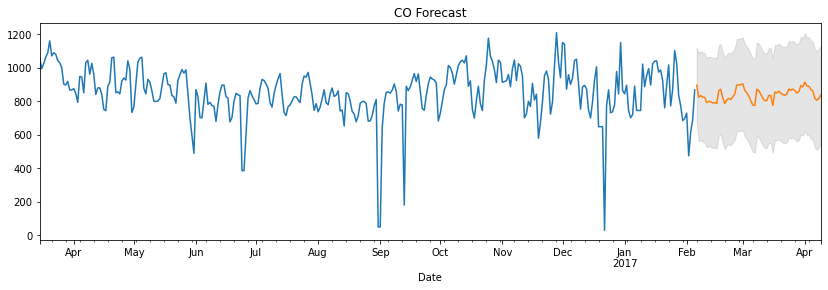

In [28]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=CO_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = CO['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("CO Forecast")
plt.show()

In [29]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=CO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('CO Forecast.csv', index=False)

## HC GAS

In [12]:
## extract HC gas only
HC = train_df.loc[train_df['Gas'] == "HC"]
HC = HC.drop(columns=['Gas'])
HC

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,729.800000
2016-03-16,9.833333,64.069791,681.441667
2016-03-17,11.292708,51.107292,806.583333
2016-03-18,12.866319,51.530903,794.258333
2016-03-19,16.016667,48.843750,755.083333
...,...,...,...
2017-02-01,5.267708,39.614930,562.650000
2017-02-02,-55.515972,-24.010417,347.480556
2017-02-03,-14.272917,28.563542,414.475000


#### ACF and PACF Plots to obtain p,d,q values

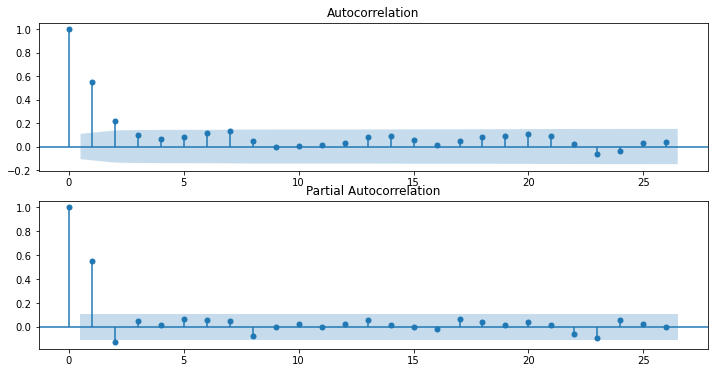

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(HC['Value'], ax=ax[0])
plot_pacf(HC['Value'], ax=ax[1])
plt.show()

### ARIMA GridSearch

In [67]:
## split into train and test data
train_data = HC[HC.index<='2016-08-20']
test_data = HC[HC.index>'2016-08-20']

In [68]:
exogHC = HC[['T','RH']]

arima_model = ARIMA(HC['Value'], order=(1,0,1), exog=exogHC).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Value   No. Observations:                  328
Model:                     ARMA(1, 1)   Log Likelihood               -1937.301
Method:                       css-mle   S.D. of innovations             88.835
Date:                Wed, 27 Jul 2022   AIC                           3886.601
Time:                        23:37:34   BIC                           3909.359
Sample:                    03-15-2016   HQIC                          3895.681
                         - 02-05-2017                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         638.3870     15.649     40.794      0.000     607.715     669.059
T               2.4072      0.506      4.753      0.000       1.415       3.400
RH              1.5935      0.443      3.600      0.000       0.726       2.461
ar.L1.Value     0.3347      0.085      3.927      0.000       0.168       0.502
ma.L1.Value     0.3322      0.084      3.945      0.000       0.167       0.497
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9880           +0.0000j            2.9880            0.0000
MA.1           -3.0099           +0.0000j            3.0099            0.5000
-----------------------------------------------------------------------------
"""

In [70]:
## define HC test set
HC_test = test_df.loc[test_df['Gas'] == "HC"]
HC_test = HC_test.drop(columns=['Gas'])

forecast = arima_model.forecast(steps=63, exog=HC_test)
forecastDF = pd.DataFrame(forecast)
forecastDF = forecastDF.drop(forecastDF.index[1:3])
forecastDF = forecastDF.T
forecastDF
forecastDF.to_csv('HC Forecast.csv', index=False)

In [19]:
orders = [(1,0,1),(1,0,2),
          (1,1,1),(1,1,2),
          (2,0,1),(2,0,2),
          (2,1,1),(2,1,2),
          (3,0,1),(3,0,2),
          (3,1,1),(3,1,2),
          (4,0,1),(4,0,2),
          (4,1,1),(4,1,2),
          (5,0,1),(5,0,2),
          (5,1,1),(5,1,2)]

metrics_df = pd.DataFrame(columns=['model', 'AIC', 'BIC'])

for order in orders:
    print("trying "+ str(order))
    try:
        arima_model = ARIMA(CO['Value'], order=order, exog=exogHC).fit()
        metrics_df = metrics_df.append({'model':order, 'AIC':arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
    except:
        print('failed')

trying (1, 0, 1)
trying (1, 0, 2)
trying (1, 1, 1)
trying (1, 1, 2)
trying (2, 0, 1)
trying (2, 0, 2)
trying (2, 1, 1)
trying (2, 1, 2)
trying (3, 0, 1)
trying (3, 0, 2)
failed
trying (3, 1, 1)
trying (3, 1, 2)
trying (4, 0, 1)
trying (4, 0, 2)
trying (4, 1, 1)
trying (4, 1, 2)
trying (5, 0, 1)
trying (5, 0, 2)
trying (5, 1, 1)
trying (5, 1, 2)


In [20]:
metrics_df = metrics_df.sort_values('AIC')
metrics_df

,model,AIC,BIC
0,"(1, 0, 1)",3755.722885,3778.480966
1,"(1, 0, 2)",3757.718608,3784.269703
4,"(2, 0, 1)",3757.719816,3784.270911
5,"(2, 0, 2)",3759.575774,3789.919883
8,"(3, 0, 1)",3760.712784,3791.056893
11,"(4, 0, 1)",3761.597481,3795.734603
15,"(5, 0, 1)",3763.913747,3801.843883
12,"(4, 0, 2)",3764.173864,3802.104000
16,"(5, 0, 2)",3764.892446,3806.615596
3,"(1, 1, 2)",4281.182675,4307.712397


### SARIMAX 

In [85]:
exogHC = HC[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(HC['Value'], order=(4,0,2),
                      seasonal_order=(2, 0, 1, 7), trend='n',exog=exogHC).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(4, 0, 2)x(2, 0, [1], 7)   Log Likelihood               -1974.951
Date:                             Thu, 28 Jul 2022   AIC                           3973.903
Time:                                     00:23:14   BIC                           4019.419
Sample:                                 03-15-2016   HQIC                          3992.062
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              3.9249      0.710      5.527      0.000       2.533       5.317
RH             0.5717      0.605      0.945      0.345      -0.614       1.757
ar.L1          0.7048      0.062     11.437      0.000       0.584       0.826
ar.L2          0.8628      0.066     12.976      0.000       0.732       0.993
ar.L3         -0.7038      0.062    -11.290      0.000      -0.826      -0.582
ar.L4          0.1363      0.060      2.262      0.024       0.018       0.254
ma.L1          0.0004      0.168      0.002      0.998      -0.328       0.329
ma.L2         -0.9996      0.113     -8.824      0.000      -1.222      -0.778
ar.S.L7        1.8168      0.544      3.337      0.001       0.750       2.884
ar.S.L14      -0.8180      0.535     -1.528      0.126      -1.867       0.231
ma.S.L7       -0.9027      0.562     -1.606      0.108      -2.005       0.199
sigma2      1.031e+04   2.42e-05   4.25e+08      0.000    1.03e+04    1.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 7.58
Prob(Q):                              0.83   Prob(JB):                         0.02
Heteroskedasticity (H):               2.50   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+25. Standard errors may be unstable.
"""

In [86]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=HC_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('HC AA Forecast.csv', index=False)

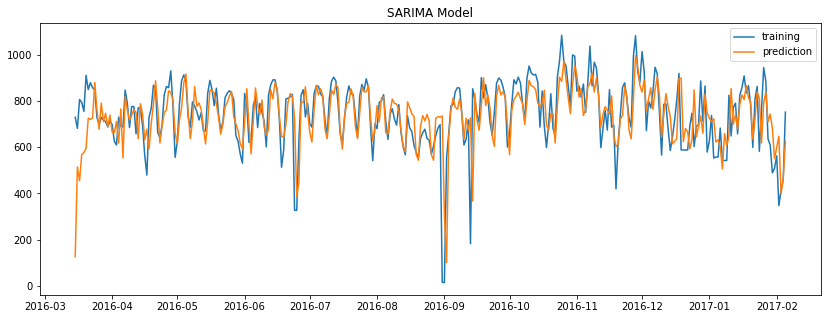

In [46]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(HC['Value'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [95]:
mae = mean_absolute_error(HC['Value'], pred)
mape = mean_absolute_percentage_error(HC['Value'], pred)
mse = mean_squared_error(HC['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,113.875666,0.428214,24002.738887,154.928173


In [47]:
## define HC test set
HC_test = test_df.loc[test_df['Gas'] == "HC"]
HC_test = HC_test.drop(columns=['Gas'])

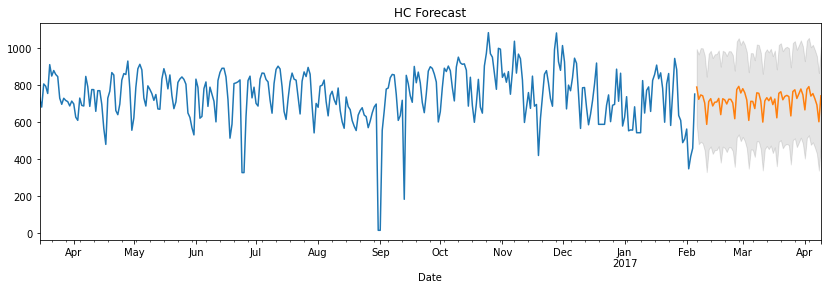

In [48]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=HC_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = HC['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("HC Forecast")
plt.show()

In [49]:
# obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=HC_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('HC Forecast.csv', index=False)

^^ less fitting might be due to outliers in 'HC'

## NO2 Gas

In [21]:
## extract NO2 gas only
NO = train_df.loc[train_df['Gas'] == "NO2"]
NO = NO.drop(columns=['Gas'])
NO

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,933.800000
2016-03-16,9.833333,64.069791,1021.750000
2016-03-17,11.292708,51.107292,881.375000
2016-03-18,12.866319,51.530903,794.527778
2016-03-19,16.016667,48.843750,800.883333
...,...,...,...
2017-02-01,5.267708,39.614930,797.647222
2017-02-02,-55.515972,-24.010417,508.180556
2017-02-03,-14.272917,28.563542,819.733333


#### ACF and PACF Plots to obtain p,d,q values

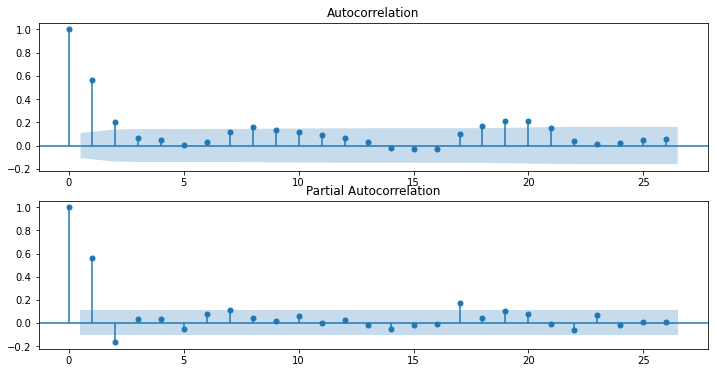

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(NO['Value'], ax=ax[0])
plot_pacf(NO['Value'], ax=ax[1])
plt.show()

In [71]:
exogNO = NO[['T','RH']]

arima_model = ARIMA(NO['Value'], order=(3,0,1), exog=exogNO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Value   No. Observations:                  328
Model:                     ARMA(3, 1)   Log Likelihood               -1991.948
Method:                       css-mle   S.D. of innovations            104.828
Date:                Wed, 27 Jul 2022   AIC                           3999.895
Time:                        23:38:44   BIC                           4030.240
Sample:                    03-15-2016   HQIC                          4012.002
                         - 02-05-2017                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         658.7992     58.941     11.177      0.000     543.277     774.321
T               4.6129      0.778      5.930      0.000       3.088       6.138
RH             -0.7908      0.675     -1.172      0.241      -2.113       0.531
ar.L1.Value     1.6192      0.064     25.340      0.000       1.494       1.744
ar.L2.Value    -0.8154      0.096     -8.463      0.000      -1.004      -0.627
ar.L3.Value     0.1888      0.057      3.321      0.001       0.077       0.300
ma.L1.Value    -0.9264      0.037    -24.792      0.000      -1.000      -0.853
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0133           -0.0000j            1.0133           -0.0000
AR.2            1.6522           -1.5798j            2.2860           -0.1214
AR.3            1.6522           +1.5798j            2.2860            0.1214
MA.1            1.0795           +0.0000j            1.0795            0.0000
-----------------------------------------------------------------------------
"""

In [77]:
## define NO test set
NO_test = test_df.loc[test_df['Gas'] == "NO2"]
NO_test = NO_test.drop(columns=['Gas'])

forecast = arima_model.forecast(steps=63, exog=NO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF = forecastDF.drop(forecastDF.index[1:3])
forecastDF = forecastDF.T
forecastDF
forecastDF.to_csv('NO2 Forecast.csv', index=False)

### ARIMA GridSearch

In [61]:
## split into train and test data
train_data = NO[NO.index<='2016-08-20']
test_data = NO[NO.index>'2016-08-20']

In [27]:
orders = [(1,0,1),(1,0,2),
          (1,1,1),(1,1,2),
          (2,0,1),(2,0,2),
          (2,1,1),(2,1,2),
          (3,0,1),(3,0,2),
          (3,1,1),(3,1,2),
          (4,0,1),(4,0,2),
          (4,1,1),(4,1,2),
          (5,0,1),(5,0,2),
          (5,1,1),(5,1,2),
          (6,0,1),(6,0,2),
          (6,1,1),(6,1,2)]

metrics_df = pd.DataFrame(columns=['model', 'AIC', 'BIC'])

for order in orders:
    print("trying "+ str(order))
    try:
        arima_model = ARIMA(NO['Value'], order=order, exog=exogNO).fit()
        metrics_df = metrics_df.append({'model':order, 'AIC':arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
    except:
        print('failed')

trying (1, 0, 1)
trying (1, 0, 2)
trying (1, 1, 1)
trying (1, 1, 2)
trying (2, 0, 1)
trying (2, 0, 2)
trying (2, 1, 1)
trying (2, 1, 2)
trying (3, 0, 1)
trying (3, 0, 2)
trying (3, 1, 1)
trying (3, 1, 2)
failed
trying (4, 0, 1)
trying (4, 0, 2)
trying (4, 1, 1)
trying (4, 1, 2)
trying (5, 0, 1)
trying (5, 0, 2)
trying (5, 1, 1)
trying (5, 1, 2)
trying (6, 0, 1)
trying (6, 0, 2)
trying (6, 1, 1)
trying (6, 1, 2)


In [28]:
metrics_df = metrics_df.sort_values('AIC')
metrics_df

,model,AIC,BIC
8,"(3, 0, 1)",3999.895412,4030.239521
5,"(2, 0, 2)",4000.940936,4031.285045
9,"(3, 0, 2)",4001.895412,4036.032534
11,"(4, 0, 1)",4001.895413,4036.032535
12,"(4, 0, 2)",4003.345842,4041.275978
16,"(5, 0, 2)",4005.291022,4047.014172
19,"(6, 0, 1)",4005.326991,4047.050140
20,"(6, 0, 2)",4006.865027,4052.381190
1,"(1, 0, 2)",4009.259917,4035.811012
0,"(1, 0, 1)",4010.879803,4033.637885


### SARIMAX

In [89]:
exogNO = NO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(NO['Value'], order=(3,0,2),
                      seasonal_order=(5, 0, 1, 7), trend='n',exog=exogNO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(3, 0, 2)x(5, 0, [1], 7)   Log Likelihood               -1981.513
Date:                             Thu, 28 Jul 2022   AIC                           3991.027
Time:                                     01:05:26   BIC                           4044.129
Sample:                                 03-15-2016   HQIC                          4012.213
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              4.8776      0.818      5.959      0.000       3.273       6.482
RH            -1.0804      0.702     -1.540      0.124      -2.455       0.295
ar.L1          0.6461      0.034     19.237      0.000       0.580       0.712
ar.L2          0.9970      0.020     50.063      0.000       0.958       1.036
ar.L3         -0.6432      0.034    -19.039      0.000      -0.709      -0.577
ma.L1          0.0070      0.052      0.135      0.893      -0.094       0.108
ma.L2         -0.9930      0.043    -22.891      0.000      -1.078      -0.908
ar.S.L7        0.8855      0.134      6.628      0.000       0.624       1.147
ar.S.L14       0.0047      0.090      0.052      0.959      -0.173       0.182
ar.S.L21       0.1365      0.092      1.477      0.140      -0.045       0.318
ar.S.L28      -0.0309      0.088     -0.352      0.725      -0.203       0.141
ar.S.L35      -0.0335      0.080     -0.418      0.676      -0.191       0.124
ma.S.L7       -0.8391      0.142     -5.930      0.000      -1.116      -0.562
sigma2      1.002e+04   1.05e-05   9.58e+08      0.000       1e+04       1e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):              1363.56
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+26. Standard errors may be unstable.
"""

In [90]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=NO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('NO2 AA Forecast.csv', index=False)

In [94]:
mae = mean_absolute_error(NO['Value'], pred)
mape = mean_absolute_percentage_error(NO['Value'], pred)
mse = mean_squared_error(NO['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,239.851272,0.464476,89820.030634,299.699901


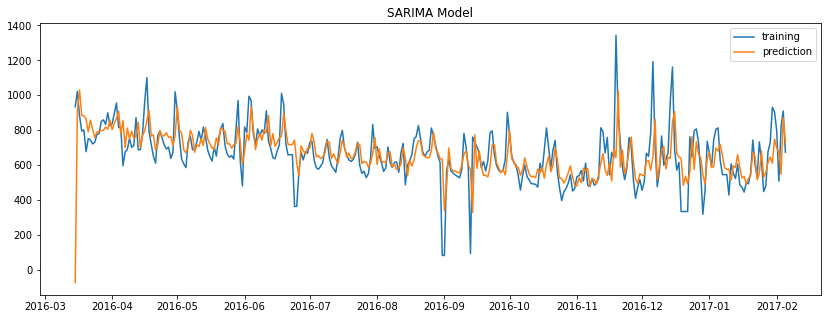

In [66]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(NO['Value'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [67]:
## define NO test set
NO_test = test_df.loc[test_df['Gas'] == "NO2"]
NO_test = NO_test.drop(columns=['Gas'])

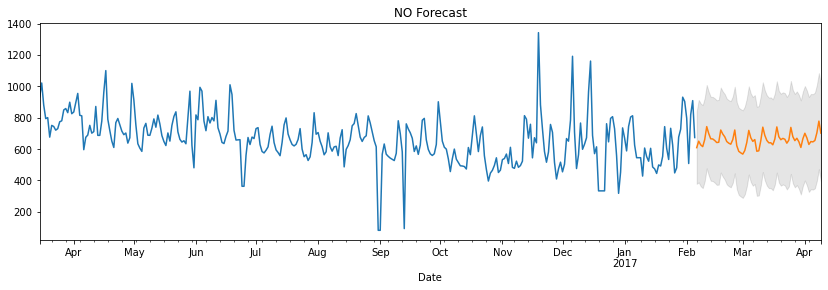

In [68]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=NO_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = NO['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("NO Forecast")
plt.show()

In [69]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=NO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('NO2 Forecast.csv', index=False)

## O3 Gas

In [29]:
## extract O3 gas only
O = train_df.loc[train_df['Gas'] == "O3"]
O = O.drop(columns=['Gas'])
O

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,876.833333
2016-03-16,9.833333,64.069791,708.025000
2016-03-17,11.292708,51.107292,867.375000
2016-03-18,12.866319,51.530903,996.625000
2016-03-19,16.016667,48.843750,987.341667
...,...,...,...
2017-02-01,5.267708,39.614930,553.180556
2017-02-02,-55.515972,-24.010417,343.500000
2017-02-03,-14.272917,28.563542,334.458333


#### ACF and PACF Plots too obtain p,d,q values

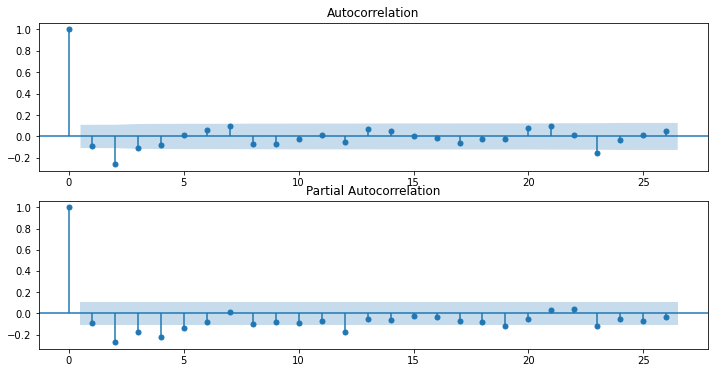

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(O['Value'], ax=ax[0])
plot_pacf(O['Value'], ax=ax[1])
plt.show()

In [78]:
exogO = O[['T','RH']]

arima_model = ARIMA(O['Value'], order=order, exog=exogO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Value   No. Observations:                  327
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2210.944
Method:                       css-mle   S.D. of innovations            207.556
Date:                Wed, 27 Jul 2022   AIC                           4443.888
Time:                        23:42:37   BIC                           4485.577
Sample:                    03-16-2016   HQIC                          4460.522
                         - 02-05-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.0511      3.525     -1.717      0.086     -12.959       0.857
T                 0.1358      0.075      1.817      0.069      -0.011       0.282
RH                0.1109      0.077      1.448      0.148      -0.039       0.261
ar.L1.D.Value    -0.1175      0.175     -0.671      0.502      -0.461       0.226
ar.L2.D.Value     0.3583      0.128      2.799      0.005       0.107       0.609
ar.L3.D.Value    -0.0879      0.069     -1.266      0.205      -0.224       0.048
ar.L4.D.Value     0.0374      0.062      0.606      0.545      -0.084       0.158
ar.L5.D.Value     0.0735      0.059      1.253      0.210      -0.041       0.188
ma.L1.D.Value    -0.1909      0.167     -1.142      0.253      -0.518       0.137
ma.L2.D.Value    -0.8091      0.167     -4.845      0.000      -1.136      -0.482
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4695           -0.0000j            1.4695           -0.0000
AR.2            0.6654           -1.7041j            1.8294           -0.1908
AR.3            0.6654           +1.7041j            1.8294            0.1908
AR.4           -1.6546           -0.1734j            1.6637           -0.4834
AR.5           -1.6546           +0.1734j            1.6637            0.4834
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.2359           +0.0000j            1.2359            0.5000
-----------------------------------------------------------------------------
"""

In [79]:
## define O test set
O_test = test_df.loc[test_df['Gas'] == "O3"]
O_test = O_test.drop(columns=['Gas'])

forecast = arima_model.forecast(steps=63, exog=O_test)
forecastDF = pd.DataFrame(forecast)
forecastDF = forecastDF.drop(forecastDF.index[1:3])
forecastDF = forecastDF.T
forecastDF
forecastDF.to_csv('O3 Forecast.csv', index=False)

### ARIMA GridSearch

In [81]:
## split into train and test data
train_data = O[O.index<='2016-08-20']
test_data = O[O.index>'2016-08-20']

In [33]:
orders = [(1,0,1),(1,0,2),
          (1,1,1),(1,1,2),
          (2,0,1),(2,0,2),
          (2,1,1),(2,1,2),
          (3,0,1),(3,0,2),
          (3,1,1),(3,1,2),
          (4,0,1),(4,0,2),
          (4,1,1),(4,1,2),
          (5,0,1),(5,0,2),
          (5,1,1),(5,1,2)]

metrics_df = pd.DataFrame(columns=['model', 'AIC', 'BIC'])

for order in orders:
    print("trying "+ str(order))
    try:
        arima_model = ARIMA(O['Value'], order=order, exog=exogO).fit()
        metrics_df = metrics_df.append({'model':order, 'AIC':arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
    except:
        print('failed')

trying (1, 0, 1)
trying (1, 0, 2)
trying (1, 1, 1)
trying (1, 1, 2)
trying (2, 0, 1)
trying (2, 0, 2)
trying (2, 1, 1)
trying (2, 1, 2)
trying (3, 0, 1)
trying (3, 0, 2)
trying (3, 1, 1)
trying (3, 1, 2)
trying (4, 0, 1)
trying (4, 0, 2)
trying (4, 1, 1)
trying (4, 1, 2)
trying (5, 0, 1)
trying (5, 0, 2)
trying (5, 1, 1)
trying (5, 1, 2)


In [34]:
metrics_df = metrics_df.sort_values('AIC')
metrics_df

,model,AIC,BIC
17,"(5, 0, 2)",4227.006222,4268.729371
0,"(1, 0, 1)",4249.692349,4272.450431
1,"(1, 0, 2)",4251.003681,4277.554776
4,"(2, 0, 1)",4251.013914,4277.565010
5,"(2, 0, 2)",4252.925092,4283.269201
8,"(3, 0, 1)",4253.105802,4283.449911
12,"(4, 0, 1)",4254.860332,4288.997454
9,"(3, 0, 2)",4254.961727,4289.098849
16,"(5, 0, 1)",4255.687608,4293.617745
13,"(4, 0, 2)",4256.678016,4294.608152


### SARIMAX

In [93]:
exogO = O[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(O['Value'], order=(2,1,1),
                      seasonal_order=(6,1,2,7), trend='n',exog=exogO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Value   No. Observations:                  328
Model:             SARIMAX(2, 1, 1)x(6, 1, [1, 2], 7)   Log Likelihood               -2047.390
Date:                                Thu, 28 Jul 2022   AIC                           4122.779
Time:                                        01:37:54   BIC                           4175.536
Sample:                                    03-15-2016   HQIC                          4143.846
                                         - 02-05-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.9889      0.981     -1.008      0.313      -2.911       0.933
RH             4.9089      0.805      6.095      0.000       3.330       6.487
ar.L1          0.7301      0.059     12.358      0.000       0.614       0.846
ar.L2         -0.1663      0.056     -2.967      0.003      -0.276      -0.056
ma.L1         -0.9999      2.903     -0.344      0.730      -6.689       4.689
ar.S.L7        0.7101      0.556      1.278      0.201      -0.379       1.799
ar.S.L14      -0.0695      0.098     -0.711      0.477      -0.261       0.122
ar.S.L21       0.0899      0.120      0.750      0.453      -0.145       0.325
ar.S.L28       0.0210      0.075      0.279      0.780      -0.127       0.169
ar.S.L35      -0.1208      0.083     -1.450      0.147      -0.284       0.042
ar.S.L42       0.1898      0.101      1.882      0.060      -0.008       0.388
ma.S.L7       -1.6938      0.563     -3.011      0.003      -2.796      -0.591
ma.S.L14       0.7057      0.489      1.443      0.149      -0.253       1.664
sigma2      1.933e+04   5.62e+04      0.344      0.731   -9.08e+04    1.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.09
Prob(Q):                              0.94   Prob(JB):                         0.21
Heteroskedasticity (H):               2.04   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=O_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('O3 AA Forecast.csv', index=False)

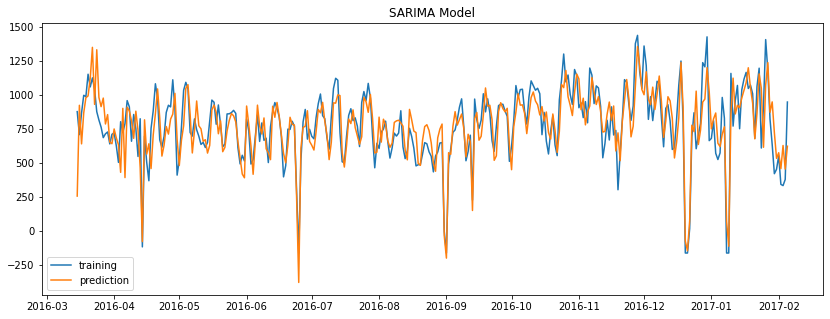

In [92]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(O['Value'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [106]:
mae = mean_absolute_error(O['Value'], pred)
mape = mean_absolute_percentage_error(O['Value'], pred)
mse = mean_squared_error(O['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,126.231659,0.304485,28692.061198,169.387311


In [87]:
## define O test set
O_test = test_df.loc[test_df['Gas'] == "O3"]
O_test = O_test.drop(columns=['Gas'])

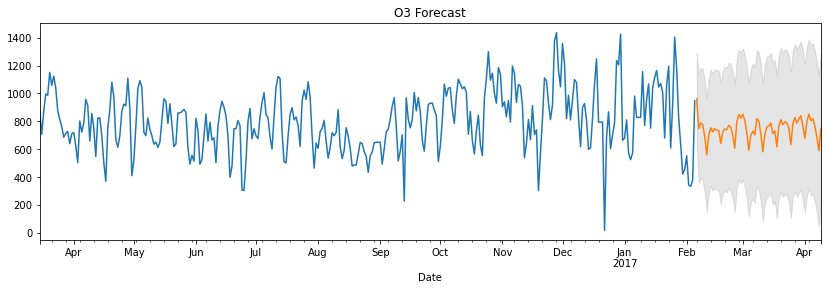

In [105]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=O_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = O['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("O3 Forecast")
plt.show()

TypeError: 'Figure' object is not subscriptable

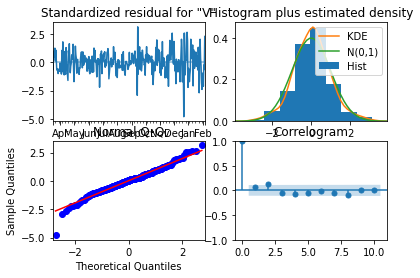

In [89]:
arima_model.plot_diagnostics()[0]

In [ ]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=O_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('O3 Forecast.csv', index=False)

NOTES

1) we assume time series is additive
2) based on decomposition plot, seasonal component does not change with the changes in trend. hence 

### REFERENCES

#### https://dziganto.github.io/python/time%20series/Introduction-to-Time-Series/
#### https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
#### https://online.stat.psu.edu/stat510/lesson/5/5.1
#### https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/